<a href="https://colab.research.google.com/github/dclocky/Deep-Learning-and-Predictive-Analysis/blob/main/Machine_Learning_Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install opencv-python

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf

In [ ]:
from google.colab import drive,files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Dataset-20250702.zip'

Archive:  /content/gdrive/MyDrive/Dataset-20250702.zip
  inflating: resized_224.zip         


In [ ]:
!unzip '/content/resized_224.zip'

Archive:  /content/resized_224.zip
   creating: resized_224/
  inflating: __MACOSX/._resized_224  
   creating: resized_224/test/
  inflating: __MACOSX/resized_224/._test  
   creating: resized_224/train/
  inflating: __MACOSX/resized_224/._train  
   creating: resized_224/validation/
  inflating: __MACOSX/resized_224/._validation  
   creating: resized_224/test/Cardiomegaly/
  inflating: __MACOSX/resized_224/test/._Cardiomegaly  
   creating: resized_224/test/No Finding/
  inflating: __MACOSX/resized_224/test/._No Finding  
   creating: resized_224/train/Cardiomegaly/
  inflating: __MACOSX/resized_224/train/._Cardiomegaly  
   creating: resized_224/train/No Finding/
  inflating: __MACOSX/resized_224/train/._No Finding  
   creating: resized_224/validation/Cardiomegaly/
  inflating: __MACOSX/resized_224/validation/._Cardiomegaly  
   creating: resized_224/validation/No Finding/
  inflating: __MACOSX/resized_224/validation/._No Finding  
  inflating: resized_224/test/Cardiomegaly/8946-5

In [ ]:
BASE_DIR = "/content/resized_224"
CATEGORIES = ["Cardiomegaly", "No Finding"]
random_seed = 42

fpath = f"{BASE_DIR}/train"
categories = os.listdir(fpath)
print("List of categories = ", categories)
print("No. of categories = ", len(categories))

List of categories =  ['Cardiomegaly', 'No Finding']
No. of categories =  2


In [ ]:
def load_dataset(dataset_type):
    dataset_path = Path(BASE_DIR) / dataset_type
    images, labels = [], []

    for class_idx, class_name in enumerate(CATEGORIES):
        class_path = dataset_path / class_name
        if not class_path.exists():
            raise ValueError(f"Missing directory: {class_path}")

        for img_file in class_path.glob("*"):
            img = cv2.imread(str(img_file))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(img).resize((224, 224))
                images.append(np.array(img))
                labels.append(class_idx)

    return np.array(images), np.array(labels)

x_train, y_train = load_dataset("train")
x_val, y_val = load_dataset("validation")
x_test, y_test = load_dataset("test")

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

for (x, y) in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x[:] = x[indices]
    y[:] = y[indices]

In [ ]:
def create_pipeline(x, y, augment=False):
    y = np.expand_dims(y, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.cache()
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = create_pipeline(x_train, y_train, augment=True)
val_ds = create_pipeline(x_val, y_val)
test_ds = create_pipeline(x_test, y_test)


Training samples:


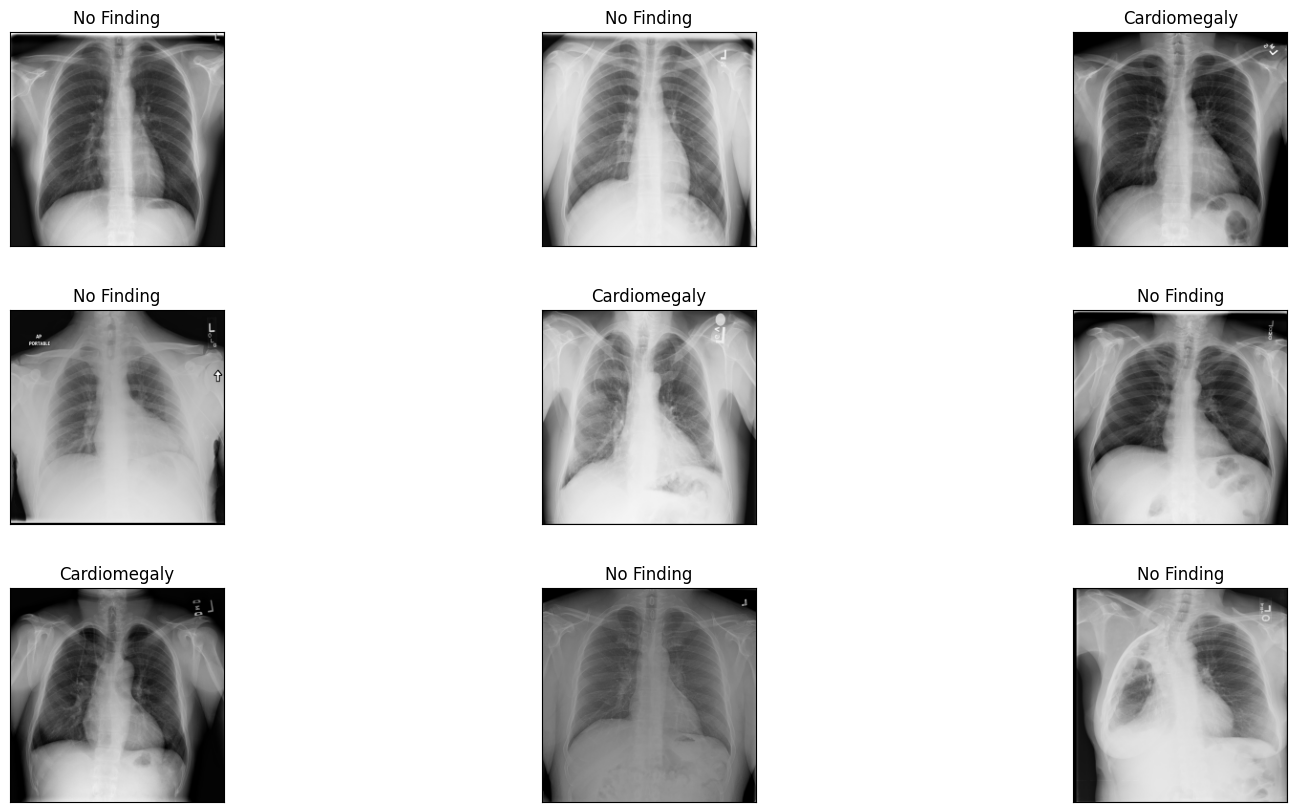


Validation samples:


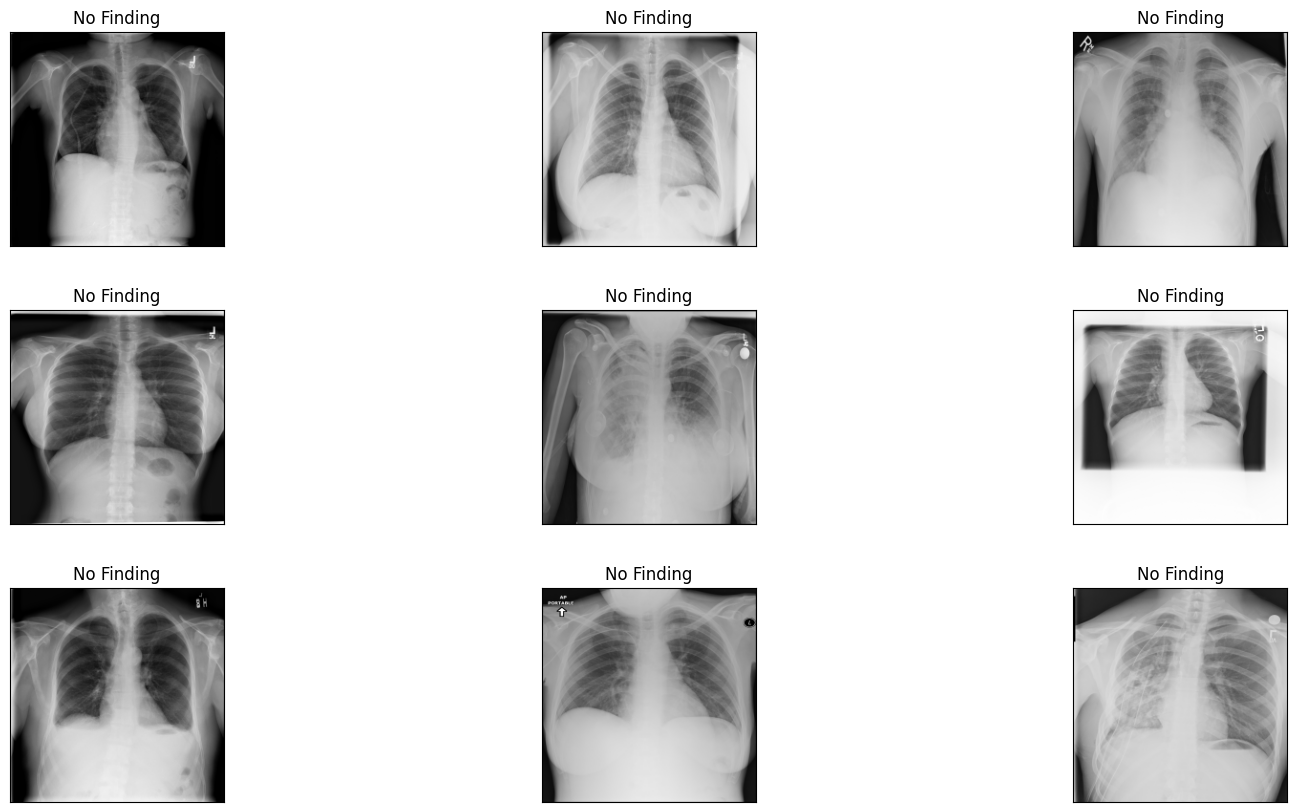


Test samples:


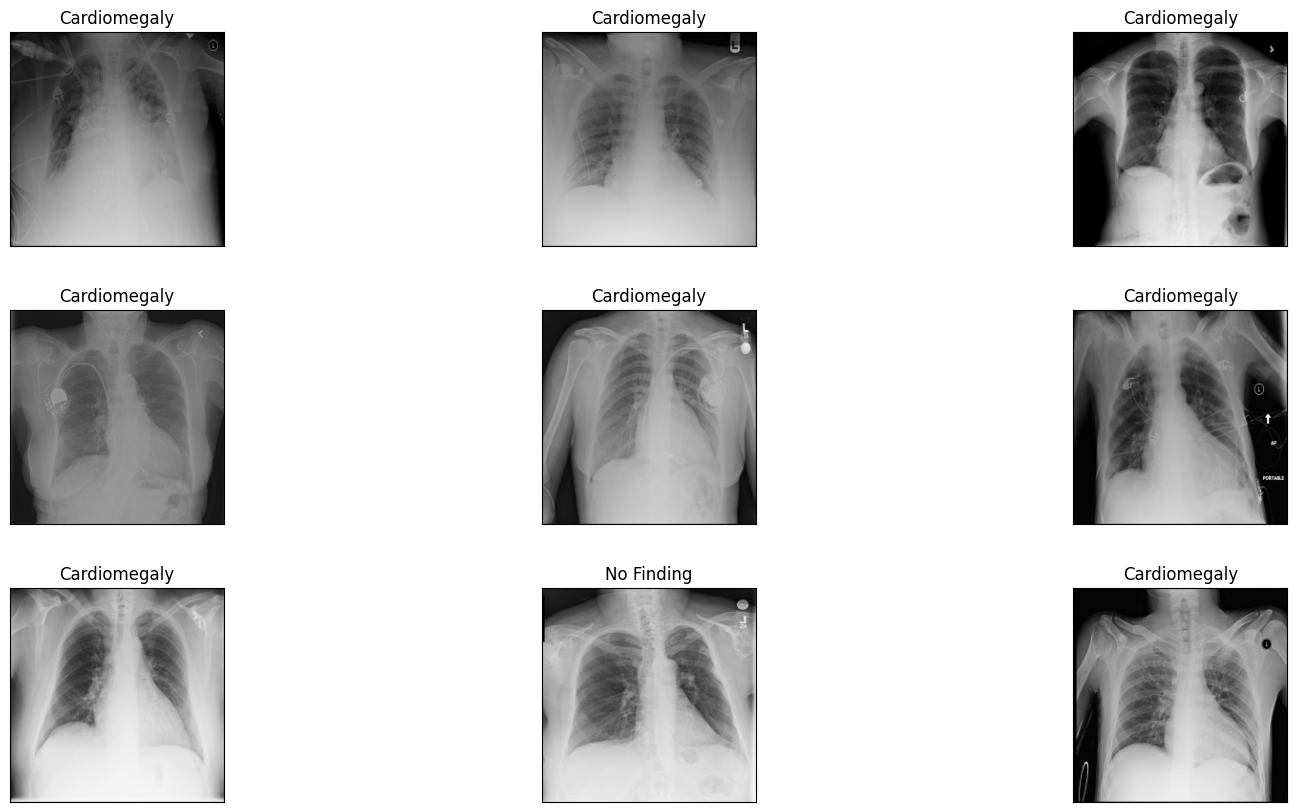

In [ ]:
def display_rand_images(images, labels, label_map=None):
    plt.figure(1, figsize=(19, 10))
    n = 0
    for i in range(9):
        n += 1
        r = np.random.randint(0, images.shape[0], 1)
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.imshow(images[r[0]])
        if label_map:
            title = label_map[labels[r[0]]]
        else:
            title = str(labels[r[0]])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.show()

label_map = {0: 'Cardiomegaly', 1: 'No Finding'}

print("\nTraining samples:")
display_rand_images(x_train, y_train, label_map)
print("\nValidation samples:")
display_rand_images(x_val, y_val, label_map)
print("\nTest samples:")
display_rand_images(x_test, y_test, label_map)

In [ ]:
random_seed = 42
np.random.seed(random_seed)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

NUM_CLASSES = 1
INPUT_SHAPE = (224, 224, 3)
weight_decay = 1e-4
initializer = "he_normal"

inputs = Input(shape=INPUT_SHAPE)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(inputs)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(512, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.Conv2D(512, (3,3), activation='relu', padding='same',
                  kernel_initializer=initializer,
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',
                 kernel_initializer=initializer,
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

custom_model = Model(inputs=inputs, outputs=outputs)

custom_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,534,529 (66.89 MB)

 Trainable params: 17,532,609 (66.88 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y_train),
                                   y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model_alexnet.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=15,
    min_lr=2e-7,
    verbose=1
)

callbacks = [earlystop, checkpoint, reduce_lr]

history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

loss, accuracy = custom_model.evaluate(test_ds)


Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 488ms/step - accuracy: 0.5362 - loss: 2.1037 - val_accuracy: 0.5807 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - accuracy: 0.6138 - loss: 1.0683 - val_accuracy: 0.5391 - val_loss: 1.1677 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 432ms/step - accuracy: 0.6463 - loss: 1.0563 - val_accuracy: 0.5599 - val_loss: 1.1563 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 461ms/step - accuracy: 0.6735 - loss: 1.0144 - val_accuracy: 0.5625 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 497ms/step - accuracy: 0.6813 - loss: 0.9995 - val_accuracy: 0.6016 - val_loss: 1.0815 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.6842 - loss: 1.0016 - val_accuracy: 0.6562 - val_loss: 1.0655 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7872 - auc: 0.8829 - loss: 0.5249
Test Loss: 0.4935
Test Accuracy: 0.8000
Test AUC: 0.8905
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Average probability for Cardiomegaly: 0.43128064
Average probability for No Finding: 0.5687194

=== Basic Metrics ===
Precision: 0.7586
Recall: 0.8800
F1 Score: 0.8148
AUC (Overall): 0.8920
Confusion Matrix:
 [[72 28]
 [12 88]]

=== Extended Metrics ===
Balanced Accuracy: 0.8000
Sensitivity (Cardiomegaly): 0.8800
Specificity (Cardiomegaly): 0.7200
Sensitivity (No Finding): 0.7200
Specificity (No Finding): 0.8800
ROC AUC (Cardiomegaly): 0.1080
ROC AUC (No Finding): 0.8920

Classification Report:
              precision    recall  f1-score   support

Cardiomegaly       0.86      0.72      0.78       100
  No Finding       0.76      0.88      0.81       100

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80    

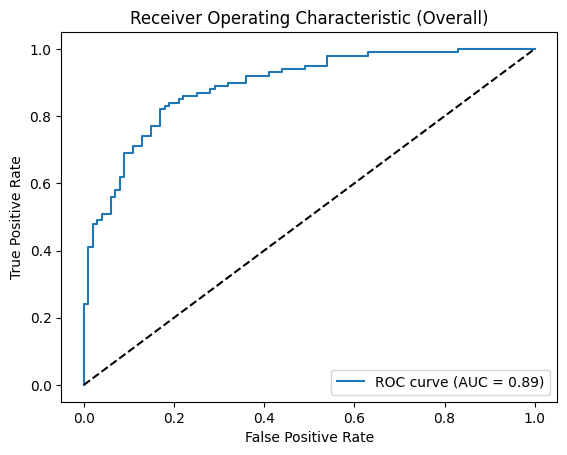

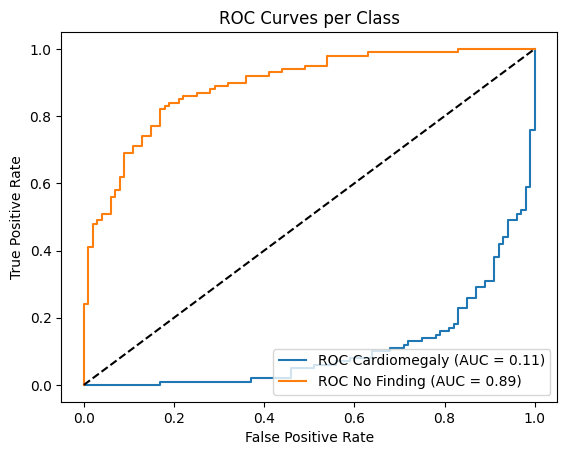

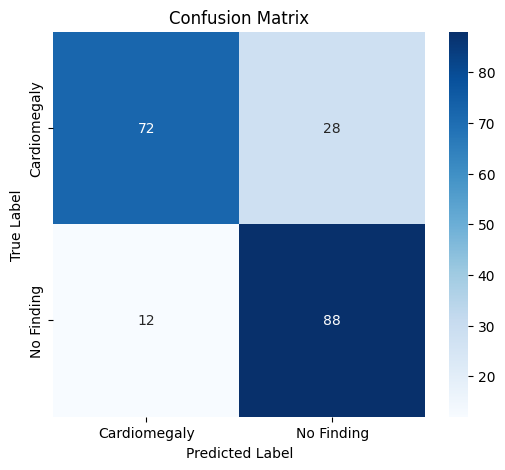

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, classification_report, balanced_accuracy_score
)

test_loss, test_acc, test_auc = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

y_pred_probs = model.predict(test_ds).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = y_test

avg_prob_cardiomegaly = np.mean(1 - y_pred_probs)
avg_prob_no_finding = np.mean(y_pred_probs)
print("Average probability for Cardiomegaly:", avg_prob_cardiomegaly)
print("Average probability for No Finding:", avg_prob_no_finding)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
auc_score = auc(fpr, tpr)

print("\n=== Basic Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC (Overall): {auc_score:.4f}")
print("Confusion Matrix:\n", confusion)

TN, FP, FN, TP = confusion.ravel()
recall_cardiomegaly = TP / (TP + FN) if (TP + FN) > 0 else 0
recall_no_finding = TN / (TN + FP) if (TN + FP) > 0 else 0
specificity_cardiomegaly = TN / (TN + FP) if (TN + FP) > 0 else 0
specificity_no_finding = TP / (TP + FN) if (TP + FN) > 0 else 0
balanced_acc = balanced_accuracy_score(y_true, y_pred)

fpr0, tpr0, _ = roc_curve(y_true, 1 - y_pred_probs)
auc_cardiomegaly = auc(fpr0, tpr0)
fpr1, tpr1, _ = roc_curve(y_true, y_pred_probs)
auc_no_finding = auc(fpr1, tpr1)

print("\n=== Extended Metrics ===")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Sensitivity (Cardiomegaly): {recall_cardiomegaly:.4f}")
print(f"Specificity (Cardiomegaly): {specificity_cardiomegaly:.4f}")
print(f"Sensitivity (No Finding): {recall_no_finding:.4f}")
print(f"Specificity (No Finding): {specificity_no_finding:.4f}")
print(f"ROC AUC (Cardiomegaly): {auc_cardiomegaly:.4f}")
print(f"ROC AUC (No Finding): {auc_no_finding:.4f}")

label_map = {0: 'Cardiomegaly', 1: 'No Finding'}
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.values())))

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Overall)')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr0, tpr0, label=f'ROC Cardiomegaly (AUC = {auc_cardiomegaly:.2f})')
plt.plot(fpr1, tpr1, label=f'ROC No Finding (AUC = {auc_no_finding:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Cardiomegaly', 'No Finding'],
    yticklabels=['Cardiomegaly', 'No Finding']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Using middle Conv2D layer for Grad-CAM: block5a_expand_conv


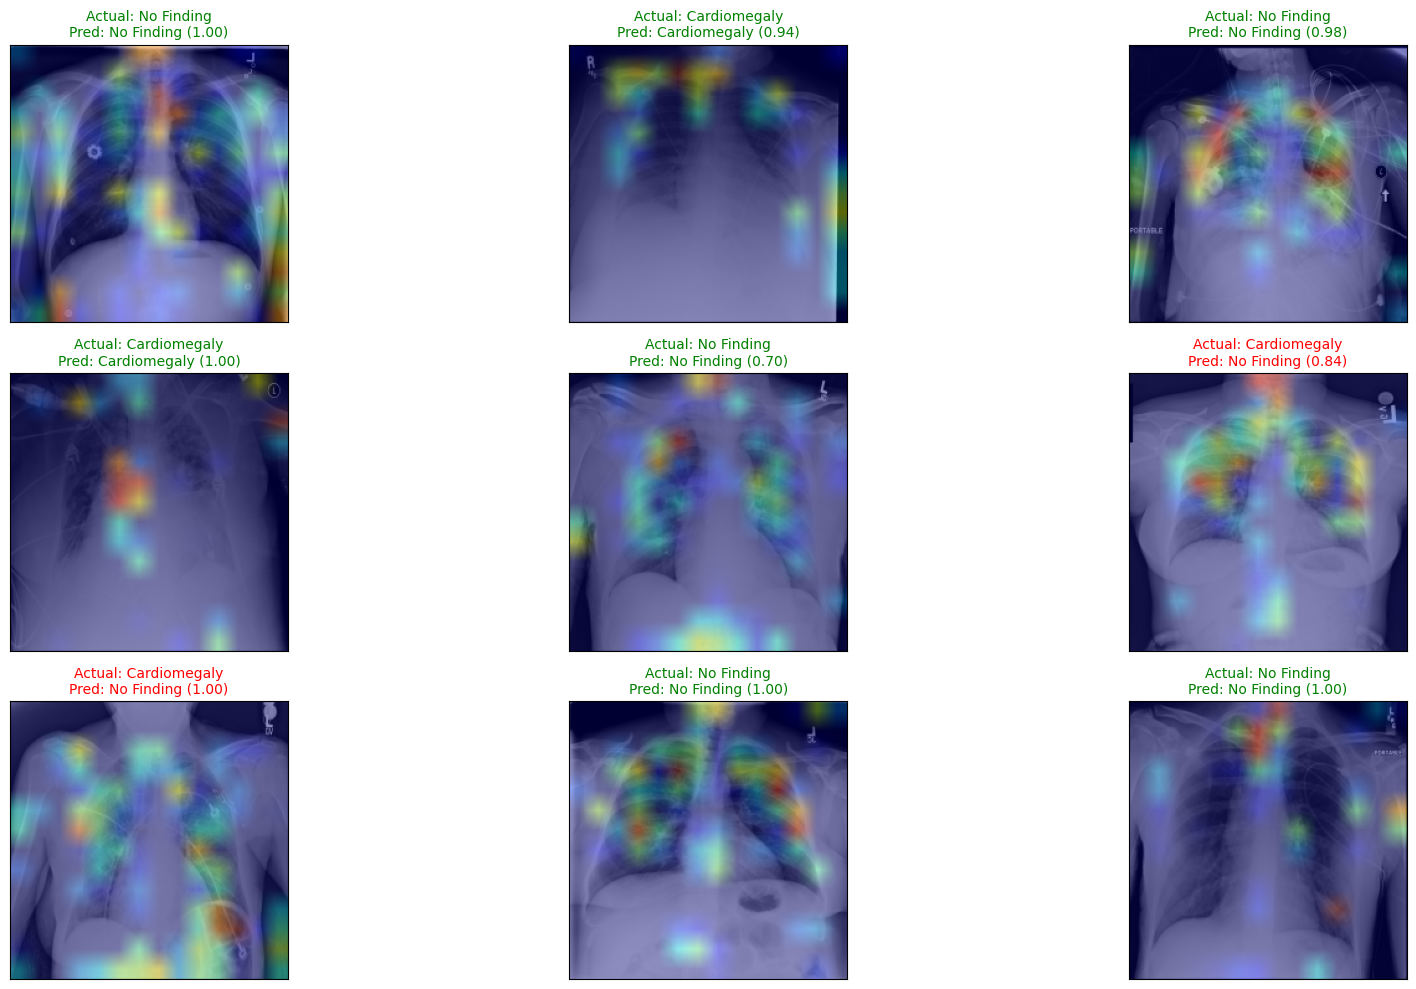

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_middle_conv_layer(model):
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    if not conv_layers:
        raise ValueError("No Conv2D layers found in the model.")
    return conv_layers[len(conv_layers)//2]

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        return heatmap
    return heatmap / np.max(heatmap)

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.image.resize(
        np.expand_dims(jet_heatmap, 0),
        (img.shape[0], img.shape[1])
    ).numpy()[0]

    img_float = img.astype(np.float32)/255.0 if img.max() > 1 else img
    superimposed_img = (1 - alpha) * img_float + alpha * jet_heatmap
    return np.clip(superimposed_img, 0, 1)



plt.figure(figsize=(19, 10))
label_map = {0: 'Cardiomegaly', 1: 'No Finding'}
middle_conv_layer = get_middle_conv_layer(model)
print("Using middle Conv2D layer for Grad-CAM:", middle_conv_layer)

for i in range(9):
    r = np.random.randint(0, x_test.shape[0])
    img = x_test[r]
    actual_class = int(y_test[r])
    actual_label = label_map[actual_class]

    img_array = tf.expand_dims(
        tf.keras.applications.efficientnet.preprocess_input(
            tf.image.resize(img, (224, 224))
        ),
        axis=0
    )

    probs = model.predict(img_array, verbose=0)
    prob_scalar = probs[0][0]
    pred_class = 1 if prob_scalar > 0.5 else 0
    pred_label = label_map[pred_class]
    confidence = prob_scalar if pred_class == 1 else 1 - prob_scalar

    heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name=middle_conv_layer)
    gradcam_img = overlay_gradcam(img, heatmap)

    color = "green" if pred_class == actual_class else "red"
    plt.subplot(3, 3, i+1)
    plt.imshow(gradcam_img)
    plt.title(f"Actual: {actual_label}\nPred: {pred_label} ({confidence:.2f})", color=color, fontsize=10)
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()


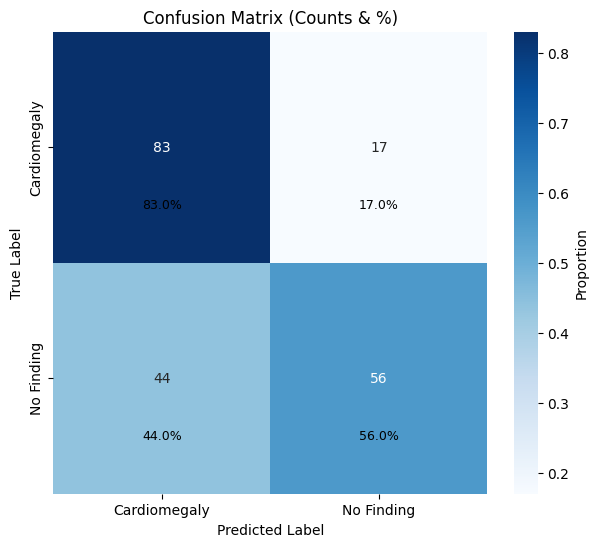

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(y_true, y_pred)

conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]

labels = ['Cardiomegaly', 'No Finding']

plt.figure(figsize=(7, 6))

sns.heatmap(
    conf_matrix_norm,
    annot=conf_matrix,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Proportion'}
)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, i + 0.75,
            f"{conf_matrix_norm[i, j]*100:.1f}%",
            ha='center', va='center',
            color='black', fontsize=9
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Counts & %)')
plt.show()


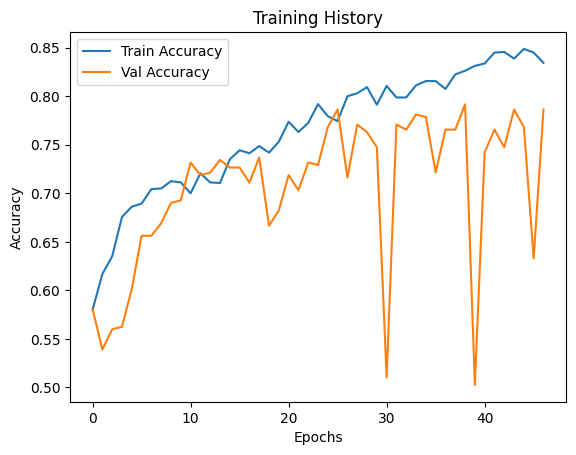

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.show()


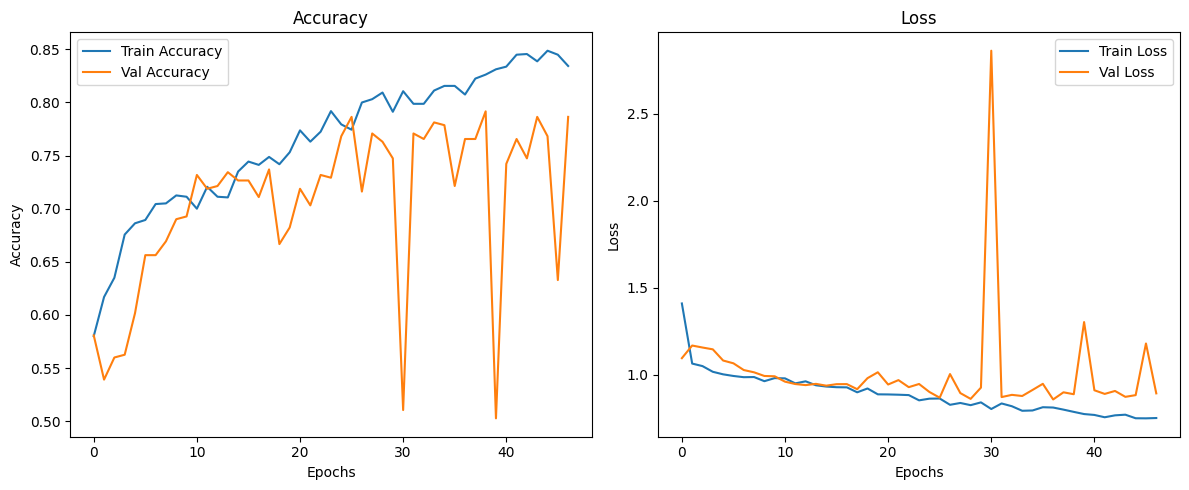

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()